In [167]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to load YOLO model
def load_yolo_model(cfg_path, weights_path, names_path):
    net = cv2.dnn.readNet(weights_path, cfg_path)
    with open(names_path, 'r') as f:
        classes = f.read().strip().split('\n')
    return net, classes

# Function to perform object detection on a single frame
def detect_objects(net, classes, frame, conf_threshold=0.5, nms_threshold=0.4):
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    detections = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []
    h, w = frame.shape[:2]


    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * w)
                center_y = int(detection[1] * h)
                width = int(detection[2] * w)
                height = int(detection[3] * h)
                x = int(center_x - width / 2)
                y = int(center_y - height / 2)
                boxes.append([x, y, x + width, y + height])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    filtered_boxes = []
    if len(indices) > 0:
        for i in indices.flatten():
            box = boxes[i]
            filtered_boxes.append(box + [confidences[i], class_ids[i]])

    return filtered_boxes

# Function to process video and extract features and detections
def process_video(video_path, yolo_model, classes, is_acc = 1, frame_rate = 100):
    cap = cv2.VideoCapture(video_path)
    frame_features = []
    box_features_list = []
    detections = []
    labels = []
    frame_ids = []

    frame_count = 0

    while cap.isOpened() and frame_count < frame_rate:
        ret, frame = cap.read()
        if not ret:
            break

        # Extract frame-level features (using a CNN, here we just flatten the frame as a placeholder)
        frame_feature = cv2.resize(frame, (224, 224)).flatten()[:4096]  # Resize to ensure it fits 4096 elements
        frame_features.append(frame_feature)
        
        # fig, axs = plt.subplots(1, 1, figsize=(30, 10))
        # axs =  axs.flatten()

        # id = 0
        # Detect objects
        boxes = detect_objects(yolo_model, classes, frame)
        if len(boxes) > 19:
            boxes = boxes[:19]  # Ensure only 19 boxes are considered

        # Create box-level features (using the same placeholder approach for now)
        box_features = []
        for box in boxes:
            x1, y1, x2, y2, confidence, class_id = box
            box_frame = frame[y1:y2, x1:x2]

            # axs[id].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            # axs[id].set_title(f'Frame: {frame}')
            # axs[id].axis('off')
            

            if box_frame.size > 0:
                box_feature = cv2.resize(box_frame, (64, 64)).flatten()[:4096]
                box_features.append(box_feature)
            else:
                box_features.append(np.zeros(4096)) 
            label = f"{classes[class_id]}: {confidence:.2f}"
            
            # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        
        # output_path = f'output_frame_{id}.jpg'
        # cv2.imwrite(output_path, frame)
        # output_frame_path = os.path.join("./testdata", f"frame_{len(frame_features) - 1}.jpg")
        # cv2.imwrite(output_frame_path, frame)
            
 # In case of invalid box

        # plt.tight_layout()
        # plt.show()
        while len(box_features) < 19:
            box_features.append(np.zeros(4096))  # Pad with zero features if less than 19 boxes

        box_features_list.append(box_features)
        # Convert boxes to a fixed size array
        while len(boxes) < 19:
            boxes.append([0, 0, 0, 0, 0.0, -1])  # Pad with default values if less than 19 boxes
        detections.append(np.array(boxes))

        # Assign a label (placeholder, replace with actual logic)
        # labels.append(label)

        video_name = video_path.split('/')[-1].split('.')[0]
        # Collect frame IDs (placeholder, replace with actual video name logic)
        frame_ids.append(f'frame_{video_name}')  # Replace with actual frame ID or video ID logic

        frame_count += 1

    cap.release()

    # Ensure we have exactly 100 frames
    while len(frame_features) < frame_rate:
        frame_features.append(np.zeros(4096))
        detections.append(np.array([[0, 0, 0, 0, 0.0, -1]] * 19))
        box_features_list.append([np.zeros(4096)] * 19)
        # labels.append([0, 1])
        frame_ids.append(f'frame_{len(frame_features)}')

    # Convert lists to numpy arrays
    frame_features = np.array(frame_features).reshape((frame_rate, 1, 4096))
    box_features = np.array(box_features_list).reshape((frame_rate, 19, 4096))
    detections = np.array(detections).reshape((frame_rate, 19, 6))
    # labels = np.array(labels)
    labels = [1, 0] if is_acc else [0, 1]  # Replace with actual condition
    labels = np.array(labels)
    frame_ids = np.array(frame_ids)

    # Combine frame-level and box-level features
    combined_features = np.concatenate((frame_features, box_features), axis=1).astype(np.float32)

    return combined_features, detections, labels, frame_ids

def main(video_path, des_path, is_acc, frame_rate):
    # Paths to YOLO files
    cfg_path = 'yolov3.cfg'
    weights_path = 'yolov3.weights'
    names_path = 'coco.names'

    # Load YOLO model
    yolo_model, classes = load_yolo_model(cfg_path, weights_path, names_path)

    # Process the video
    # video_path = 'input_video.mp4'
    data, det, labels, ID = process_video(video_path, yolo_model, classes, is_acc, frame_rate)

    if is_acc:
        labels = [0, 1]
    else:
        labels = [1, 0]
    labels =  np.array(labels)
    # Print the sizes of the arrays
    print("Size of data:", data.shape)
    print("Size of det:", det.shape)
    print("Size of labels:", labels.shape)
    print("Size of ID:", ID.shape)

    # Save to .npz file
    np.savez(des_path , data=data, det=det, labels=labels, ID=ID)

    print("NPZ file successfully created.")

In [168]:
import os

input_folder = 'input_clips/positive'
output_folder = 'data/test/obj_feat/testing/'
video_files = [f for f in os.listdir(input_folder) if f.endswith('.mp4')]
    
for video_file in video_files:
    video_path = os.path.join(input_folder, video_file)
    output_path = os.path.join(output_folder, os.path.splitext(video_file)[0]+ '.npz')
    main(video_path, output_path, 1, 100)

Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file succes

In [169]:
import os

input_folder = 'input_clips/negative'
output_folder = 'data/test/obj_feat/testing/'
video_files = [f for f in os.listdir(input_folder) if f.endswith('.mp4')]
    
for video_file in video_files:
    video_path = os.path.join(input_folder, video_file)
    output_path = os.path.join(output_folder, os.path.splitext(video_file)[0]+ '.npz')
    main(video_path, output_path, 0, 100)

Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.
Size of data: (100, 20, 4096)
Size of det: (100, 19, 6)
Size of labels: (2,)
Size of ID: (100,)
NPZ file successfully created.


I3d

In [111]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

In [112]:
def load_yolo_model(cfg_path, weights_path, names_path):
    net = cv2.dnn.readNet(weights_path, cfg_path)
    with open(names_path, 'r') as f:
        classes = f.read().strip().split('\n')
    return net, classes

# Paths to YOLO files
cfg_path = 'yolov3.cfg'
weights_path = 'yolov3.weights'
names_path = 'coco.names'

# Load YOLO model
yolo_model, classes = load_yolo_model(cfg_path, weights_path, names_path)
print("YOLO model loaded.")

YOLO model loaded.


In [114]:
def detect_objects(net, classes, frame, conf_threshold=0.5, nms_threshold=0.4):
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    detections = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []
    h, w = frame.shape[:2]

    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * w)
                center_y = int(detection[1] * h)
                width = int(detection[2] * w)
                height = int(detection[3] * h)
                x = int(center_x - width / 2)
                y = int(center_y - height / 2)
                boxes.append([x, y, x + width, y + height])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    filtered_boxes = []
    if len(indices) > 0:
        for i in indices.flatten():
            box = boxes[i]
            filtered_boxes.append(box + [confidences[i], class_ids[i]])

    return filtered_boxes

In [142]:
class I3DFeatureExtractor(nn.Module):
    def __init__(self):
        super(I3DFeatureExtractor, self).__init__()
        self.i3d = models.video.r3d_18(pretrained=True)
        self.i3d.fc = nn.Identity()  # Remove the classification layer

    def forward(self, x):
        return self.i3d(x)

# Initialize I3D model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
i3d_model = I3DFeatureExtractor().to(device)
i3d_model.eval()
print("I3D model loaded.")

I3D model loaded.


In [7]:
def process_video_I3d(video_path, yolo_model, classes, i3d_model, output_dir, target_fps=20, default_frame_count=100):
    cap = cv2.VideoCapture(video_path)
    frame_features = []
    temporal_edges = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    frame_count = 0
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / target_fps)
    prev_boxes = np.zeros((19, 6))

    while cap.isOpened() and frame_count < default_frame_count:
        print("Frame count: ", frame_count)
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            # Extract global features using I3D
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            img_tensor = transform(img).unsqueeze(0).to(device)
            img_tensor = img_tensor.unsqueeze(2).repeat(1, 1, 16, 1, 1)  # Create a fake video clip with 16 frames
            with torch.no_grad():
                feature = i3d_model(img_tensor).cpu().numpy().flatten()
                # print(feature.shape)
            frame_features.append(feature.astype(np.float32))

            # Detect objects
            boxes = detect_objects(yolo_model, classes, frame)
            if len(boxes) > 0:
                boxes = np.array(boxes[:19])  # Ensure only 19 boxes are considered
            else:
                boxes = np.zeros((19, 6))  # Initialize with zeros if no boxes detected

            if boxes.shape[0] < 19:
                boxes = np.vstack([boxes, np.zeros((19 - boxes.shape[0], 6))])  # Pad with zeros if less than 19 boxes

            # Calculate temporal edges between objects
            # frame_temporal_edges = np.zeros((19, 19))
            # for i, box1 in enumerate(prev_boxes):
            #     for j, box2 in enumerate(boxes):
            #         edge = calculate_edge(box1, box2)
            #         frame_temporal_edges[i, j] = edge
            # temporal_edges.append(frame_temporal_edges)

            prev_boxes = boxes

        frame_count += 1

    cap.release()

    # Ensure we have exactly 50 frames
    while len(frame_features) < default_frame_count:
        frame_features.append(np.zeros([512,]))

    frame_features = np.array(frame_features)

    np.save(output_dir, frame_features)
    print("NPY files successfully created to :: ", output_dir)

def calculate_edge(box1, box2):
    # Calculate the distance between the centers of two bounding boxes
    x1_center = (box1[0] + box1[2]) / 2
    y1_center = (box1[1] + box1[3]) / 2
    x2_center = (box2[0] + box2[2]) / 2
    y2_center = (box2[1] + box2[3]) / 2
    distance = np.sqrt((x1_center - x2_center) ** 2 + (y1_center - y2_center) ** 2)
    return distance

In [177]:
# Process the video

process_video_I3d('./input_clips/positive/clip_0014.mp4', yolo_model, classes, i3d_model, "data/test/i3d_feat/testing/positive/", target_fps=20)

# input_folder = 'input_clips/positive'
# output_folder = 'data/test/i3d_feat/testing/positive/'
# video_files = [f for f in os.listdir(input_folder) if f.endswith('.mp4')]
    
# for video_file in video_files:
#     video_path = os.path.join(input_folder, video_file)
#     output_path = os.path.join(output_folder, os.path.splitext(video_file)[0]+ '.npy')
    # process_video_I3d(video_path, yolo_model, classes, i3d_model, output_path, target_fps=20)

Frame count:  0
Frame count:  1
Frame count:  2
Frame count:  3
Frame count:  4
Frame count:  5
Frame count:  6
Frame count:  7
Frame count:  8
Frame count:  9
Frame count:  10
Frame count:  11
Frame count:  12
Frame count:  13
Frame count:  14
Frame count:  15
Frame count:  16
Frame count:  17
Frame count:  18
Frame count:  19
Frame count:  20
Frame count:  21
Frame count:  22
Frame count:  23
Frame count:  24
Frame count:  25
Frame count:  26
Frame count:  27
Frame count:  28
Frame count:  29
Frame count:  30
Frame count:  31
Frame count:  32
Frame count:  33
Frame count:  34
Frame count:  35
Frame count:  36
Frame count:  37
Frame count:  38
Frame count:  39
Frame count:  40
Frame count:  41
Frame count:  42
Frame count:  43
Frame count:  44
Frame count:  45
Frame count:  46
Frame count:  47
Frame count:  48
Frame count:  49
Frame count:  50
Frame count:  51
Frame count:  52
Frame count:  53
Frame count:  54
Frame count:  55
Frame count:  56
Frame count:  57
Frame count:  58
Frame c

In [162]:
input_folder = 'input_clips/negative'
output_folder = 'data/test/i3d_feat/testing/negative/'
video_files = [f for f in os.listdir(input_folder) if f.endswith('.mp4')]
    
for video_file in video_files:
    video_path = os.path.join(input_folder, video_file)
    output_path = os.path.join(output_folder, os.path.splitext(video_file)[0]+ '.npy')
    process_video_I3d(video_path, yolo_model, classes, i3d_model, output_path, target_fps=20)

Frame count:  0
(512,)
Frame count:  1
(512,)
Frame count:  2
(512,)
Frame count:  3
(512,)
Frame count:  4
(512,)
Frame count:  5
(512,)
Frame count:  6
(512,)
Frame count:  7
(512,)
Frame count:  8
(512,)
Frame count:  9
(512,)
Frame count:  10
(512,)
Frame count:  11
11
NPY files successfully created to ::  data/test/i3d_feat/testing/negative/


Shape of frame_features: (100, 2048)


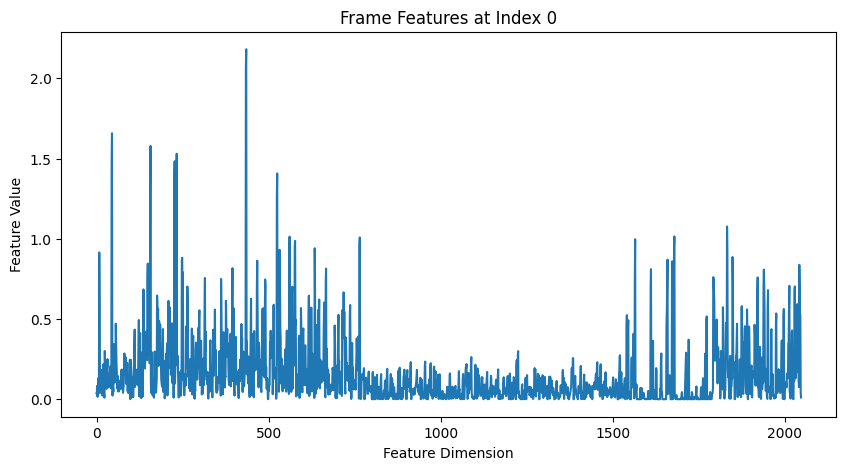

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Load the npy files
frame_features = np.load('./data/dad/i3d_feat/testing/negative/000839.npy')
# temporal_edges = np.load('output_features/temporal_edges.npy')

# Print the shapes of the arrays
print(f"Shape of frame_features: {frame_features.shape}")
# print(f"Shape of temporal_edges: {temporal_edges.shape}")

def visualize_frame_features(frame_features, frame_idx):
    plt.figure(figsize=(10, 5))
    plt.plot(frame_features[frame_idx])
    plt.title(f"Frame Features at Index {frame_idx}")
    plt.xlabel("Feature Dimension")
    plt.ylabel("Feature Value")
    plt.show()

# Visualize frame features for a specific frame
visualize_frame_features(frame_features, frame_idx=0)


In [139]:
import cv2
import numpy as np

def main(video_path, output_path, frame_count = 100):
    cap = cv2.VideoCapture(video_path)

    # Video properties
    fps = 20
    duration = 5
    total_frames = fps * duration

    # Initialize list to store statistics
    frame_stats = []

    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Append statistics to the list
        frame_stats.append([frame_width, frame_height])

    i
    # Release the video capture object
    cap.release()

     # Ensure the list has the required number of frames
    while len(frame_stats) < frame_count:
        frame_stats.append([0, 0])



    # Convert the list to a 2D numpy array
    frame_stats_array = np.array(frame_stats)

    print(frame_stats_array.shape)  # Should print (100, 2)
    np.save(output_path, frame_stats_array)

if __name__ == '__main__':

    input_folder = 'input_clips/negative'
    output_folder = 'data/test/frames_stats/testing/negative'
    video_files = [f for f in os.listdir(input_folder) if f.endswith('.mp4')]
    
    for video_file in video_files:
        video_path = os.path.join(input_folder, video_file)
        output_path = os.path.join(output_folder, os.path.splitext(video_file)[0] + '.npy')
        main(video_path, output_path, 100)

    input_folder = 'input_clips/positive'
    output_folder = 'data/test/frames_stats/testing/positive'
    video_files = [f for f in os.listdir(input_folder) if f.endswith('.mp4')]
    
    for video_file in video_files:
        video_path = os.path.join(input_folder, video_file)
        output_path = os.path.join(output_folder, os.path.splitext(video_file)[0] + '.npy')
        main(video_path, output_path, 100)


(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)


In [2]:
import numpy as np
import torchvision.transforms as transforms

# Load the numpy array from a .npy file
double_array = np.load('/Users/sacithrangana/Desktop/Msc/AAI/gitrepo/Graph_Code/Graph-Graph/data/dad/i3d_feat/testing/positive/000456.npy')
# double_array1 = np.load('/Users/sacithrangana/Desktop/Msc/AAI/gitrepo/Graph_Code/Graph-Graph/data/test/obj_feat/testing/0007.npz')
# double_array2 = np.load('/Users/sacithrangana/Desktop/Msc/AAI/gitrepo/Graph_Code/Graph-Graph/data/test/obj_feat/testing/0001.npz')
# double_array1 = np.load('/Users/sacithrangana/Desktop/Msc/AAI/gitrepo/Graph_Code/Graph-Graph/data/test/frames_stats/testing/negative/clip_0000.npy')

# print(double_array.dtype)
# print(double_array1.dtype)
# test = double_array1['data'].astype(np.float16)
#transform = transforms.Compose([transforms.ToTensor(),])
# all_img_feat = np.load(double_array)
#all_img_feat = transform(double_array).squeeze(0)

#all_img_feat1 = transform(double_array1).squeeze(0)
# print("all_img_feat.shape")
# print(double_array1)
# print(double_array1.shape)

# print("all_img_feat.shape")
# print(double_array)

print(double_array.shape)
# print(double_array2['labels'])
# print(double_array1.shape)

# print("all_img_feat.shape------")
# print(double_array1['labels'].shape)

#n_frames = 1000
#Precision = np.zeros((n_frames))
#print("Precision.shape")
#print(Precision)
# all_feat = torch.from_numpy(double_array1['data'].astype(np.float16))[:, 1:, :]
# all_bbox = torch.from_numpy(double_array1['det']).float()  #(x1, y1, x2, y2, cls, accident/no acc)bottom left and top right coordinates

# curr_vid_label = int(double_array1['labels'][1])   

# all_feat1 = torch.from_numpy(double_array['data'])[:, 1:, :]
# all_bbox1 = torch.from_numpy(double_array['det']).float()  #(x1, y1, x2, y2, cls, accident/no acc)bottom left and top right coordinates

# curr_vid_label1= int(double_array['labels'][1])   

# print(all_feat1.dtype)
# print(all_bbox1.dtype)
# print(curr_vid_label1.dtype)

# print('curr_vid_label1.dtype')

# print(all_feat.dtype)
# print(all_bbox.dtype)
# print(curr_vid_label.dtype)
# print(all_bbox.dtype)





# float_array = double_array.astype(np.float32)
# np.save('./data/test/i3d_feat/testing/positive/clip_0014_new.npy', float_array)

(100, 2048)


In [13]:
!pip install i3dFeatureExtraction

  Using cached cycler-0.11.0-py3-none-any.whl.metadata (785 bytes)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 290.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 670.5 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Using cached itsdangerous-2.1.2-py3-none-any.whl.metadata (2.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.4 MB/s eta 0:00:00
  Using cached zipp-3.15.0-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 2.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 1.4 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.11.0-py3-none-any.

In [ ]:
from i3dFeatureExtraction import FeatureExtraction
FeatureExtraction.generate(
    datasetpath="/Users/sacithrangana/Desktop/Msc/AAI/gitrepo/Graph_Code/Graph-Graph/input_clips/positive/clip_0014.mp4",
    multiplefiles = False
)

: 

In [6]:
%pip install charset_normalizer


235.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


NPZ

In [ ]:
from mmdet.apis import init_detector, inference_detector
import mmcv

# Specify the config file and checkpoint file
config_file = 'path/to/your/config/file.py'
checkpoint_file = 'path/to/your/checkpoint/file.pth'

# Initialize the detector on CPU
model = init_detector(config_file, checkpoint_file, device='cpu')

# Perform inference on an image
result = inference_detector(model, 'path/to/test/image.jpg')

# Save the result
model.show_result('path/to/test/image.jpg', result, out_file='result.jpg')


Testing I#D

In [3]:
! git clone https://github.com/v-iashin/video_features.git


Cloning into 'video_features'...
remote: Enumerating objects: 1435, done.
remote: Counting objects: 100% (387/387), done.
remote: Compressing objects: 100% (132/132), done.
error: RPC failed; curl 92 HTTP/2 stream 5 was not closed cleanly: CANCEL (err 8)
error: 742 bytes of body are still expected
fetch-pack: unexpected disconnect while reading sideband packet
fatal: early EOF
fatal: fetch-pack: invalid index-pack output
Requested omegaconf==2.0.6 from https://files.pythonhosted.org/packages/d0/eb/9d63ce09dd8aa85767c65668d5414958ea29648a0eec80a4a7d311ec2684/omegaconf-2.0.6-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    PyYAML (>=5.1.*)
            ~~~~~~^
Please use pip<24.1 if you need to use this version.
ERROR: Ignored the following yanked versions: 1.0.0, 1.0.1, 1.0.2, 2.0.0rc1, 2.0.0rc2, 2.0.0rc22, 2.0.0rc23, 2.0.0rc24, 2.0.0rc25, 2.0.0rc26, 2.0.0rc27, 2.0.0rc28, 2.0.0rc29, 2.0.1rc1, 2.0.1rc2, 2.0.1rc3, 2.0.1rc4, 2.0.1rc5, 2.2.0
E

In [4]:
! pip install omegaconf

  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144574 sha256=ae591224eae2327d46c1bfebf795f8bc20536664f26086bc6bc785a37d738f9f
  Stored in directory: /Users/sacithrangana/Library/Caches/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime


In [5]:
%cd video_features

[Errno 2] No such file or directory: 'video_features'
/Users/sacithrangana/Desktop/Msc/AAI/gitrepo/Graph_Code/Graph-Graph


In [7]:
from models.i3d.extract_i3d import ExtractI3D
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(0)

KeyboardInterrupt: 

In [10]:

import os

# Specify the folder containing your files
folder_path = '/Users/sacithrangana/Desktop/Msc/AAI/gitrepo/Graph_Code/Graph-Graph/data/sutd/obj_feat/test'

# Specify the output text file name
output_file = 'file_names.txt'

# Open the file in write mode
with open(output_file, 'w') as file:
    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        file.write(f"{filename}\n")  # Write each file name on a new line

print(f"File names have been saved to {output_file}")

File names have been saved to file_names.txt
